In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd
import skforecast

print(skforecast.__version__)

/home/joaquin/Documents/GitHub/skforecast
0.18.0


In [2]:
# Libraries
# ==============================================================================
from aeon.forecasting.stats import ARIMA, ETS
from skforecast.sarimax import Sarimax
from skforecast.stats import Arar
from skforecast.experimental import ForecasterStats
from skforecast.experimental import backtesting_stats
from skforecast.experimental import grid_search_stats
from skforecast.model_selection import TimeSeriesFold

import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
from skforecast.datasets import fetch_dataset
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="jupyter_client")
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

In [3]:
# Download data
# ==============================================================================
data = fetch_dataset(name='fuel_consumption', raw=True)
data = data[['Fecha', 'Gasolinas']]
data = data.rename(columns={'Fecha':'date', 'Gasolinas':'litters'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.loc[:'1990-01-01 00:00:00']
data = data.asfreq('MS')
data['y'] = data['litters']
data = data[['y']]

╭──────────────────────────────── fuel_consumption ────────────────────────────────╮
│ Description:                                                                     │
│ Monthly fuel consumption in Spain from 1969-01-01 to 2022-08-01.                 │
│                                                                                  │
│ Source:                                                                          │
│ Obtained from Corporación de Reservas Estratégicas de Productos Petrolíferos and │
│ Corporación de Derecho Público tutelada por el Ministerio para la Transición     │
│ Ecológica y el Reto Demográfico. https://www.cores.es/es/estadisticas            │
│                                                                                  │
│ URL:                                                                             │
│ https://raw.githubusercontent.com/skforecast/skforecast-                         │
│ datasets/main/data/consumos-combustibles-mensual.csv                             │
│                                                                                  │
│ Shape: 644 rows x 6 columns                                                      │
╰──────────────────────────────────────────────────────────────────────────────────╯

Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


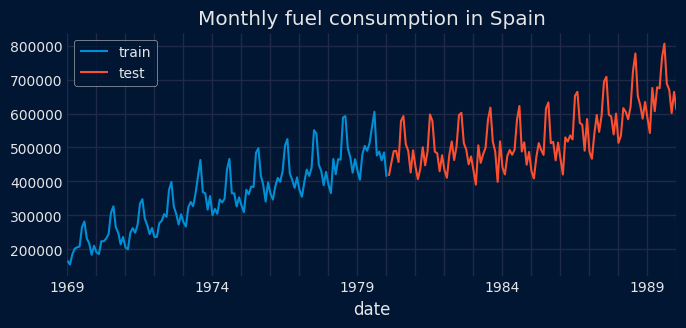

In [4]:
# Train-test dates
# ======================================================================================
set_dark_theme()
end_train = '1980-01-01 23:59:59'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

# Regressors: ARAR, ARIMA, ETS and SARIMAX with skforecast and aeon

In [5]:
# ARIMA model with skforecast.Sarimax
# ==============================================================================
sarimax = Sarimax(order=(1, 1, 1))
sarimax.fit(y=data_train['y'])
display(sarimax.summary())
predictions_sarimax = sarimax.predict(steps=12)
predictions_sarimax

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  133
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1595.854
Date:                Sat, 27 Sep 2025   AIC                           3197.708
Time:                        10:09:30   BIC                           3206.356
Sample:                    01-01-1969   HQIC                          3201.222
                         - 01-01-1980                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6686      0.159      4.215      0.000       0.358       0.980
ma.L1         -0.8934      0.105     -8.470      0.000      -1.100      -0.687
sigma2      1.973e+09   2.72e-11   7.24e+19      0.000    1.97e+09    1.97e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 1.00
Prob(Q):                              0.66   Prob(JB):                         0.61
Heteroskedasticity (H):               2.17   Skew:                             0.21
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.99e+35. Standard errors may be unstable.
"""

,pred
1980-02-01,430523.028684
1980-03-01,441646.169064
1980-04-01,449082.965650
1980-05-01,454055.117540
1980-06-01,457379.437915
1980-07-01,459602.038149
1980-08-01,461088.041676
1980-09-01,462081.565590
1980-10-01,462745.823613
1980-11-01,463189.938462


In [6]:
%%timeit -r 10 -n 2
arima = Sarimax(order=(1, 1, 1))
arima.fit(y=data_train['y'])

78.4 ms ± 18.6 ms per loop (mean ± std. dev. of 10 runs, 2 loops each)


In [7]:
# ARIMA model with aeon
# ==============================================================================
arima = ARIMA(p=1, d=1, q=1, iterations=1000)
predictions_arima = arima.iterative_forecast(y=data_train['y'], prediction_horizon=12)
predictions_arima

array([433252.91064898, 445437.18974453, 453102.7728544 , 457925.47627031,
       460959.61834461, 462868.50996268, 464069.4646709 , 464825.02994111,
       465300.38415191, 465599.44716425, 465787.59882741, 465905.97203603])

In [8]:
%%timeit -r 10 -n 2
arima = ARIMA(p=1, d=1, q=1, iterations=1000)
arima.fit(y=data_train['y'])

773 μs ± 152 μs per loop (mean ± std. dev. of 10 runs, 2 loops each)


In [9]:
# ETS model with aeon
# ==============================================================================
ets = ETS(seasonal_period=1)
predictions_ets = ets.iterative_forecast(y=data_train['y'], prediction_horizon=12)
predictions_ets

array([420168.42438479, 420168.42438479, 420168.42438479, 420168.42438479,
       420168.42438479, 420168.42438479, 420168.42438479, 420168.42438479,
       420168.42438479, 420168.42438479, 420168.42438479, 420168.42438479])

# ForecasterStats


In [10]:
# Create and fit Sarimax
# ==============================================================================
forecaster = ForecasterStats(
                 regressor=Sarimax(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )
forecaster.fit(y=data_train['y'], suppress_warnings=True)

predictions = forecaster.predict(steps=36)
predictions.head(3)

1980-02-01    417933.097548
1980-03-01    482692.169878
1980-04-01    505046.848875
Freq: MS, Name: pred, dtype: float64

In [11]:
%%timeit -r 10 -n 2
forecaster = ForecasterStats(
                 regressor=Sarimax(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )
forecaster.fit(y=data_train['y'], suppress_warnings=True)
forecaster.predict(steps=36)

2.7 s ± 1.16 s per loop (mean ± std. dev. of 10 runs, 2 loops each)


In [12]:
# Create and fit ARIMA aeon
# ==============================================================================
forecaster = ForecasterStats(
                 regressor=ARIMA(p=12, d=1, q=1, iterations=1000),
             )

forecaster.fit(y=data_train['y'], suppress_warnings=True)
predictions = forecaster.predict(steps=36)
predictions.head(3)

1980-02-01    407635.445047
1980-03-01    494394.050313
1980-04-01    501856.686067
Freq: MS, Name: pred, dtype: float64

In [13]:
%%timeit -r 10 -n 2
forecaster = ForecasterStats(
                 regressor=ARIMA(p=12, d=1, q=1, iterations=1000),
             )

forecaster.fit(y=data_train['y'], suppress_warnings=True)
forecaster.predict(steps=36)

11 ms ± 862 μs per loop (mean ± std. dev. of 10 runs, 2 loops each)


In [14]:
# Backtesting with ForecasterStats sarimax statsmodels
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = False,
        fixed_train_size   = False,
)
forecaster = ForecasterStats(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), maxiter=500),
             )
metric_sarimax, pred_sarimax = backtesting_stats(
                    forecaster = forecaster,
                    y          = data['y'],
                    cv         = cv,
                    metric     = 'mean_absolute_error'
                )


  0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
# Backtesting with ForecasterStats arima aeon
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = False,
        fixed_train_size   = False,
)
forecaster = ForecasterStats(
                 regressor=ARIMA(p=13, d=1, q=13, iterations=1000),
             )
metric_arima, pred_arima = backtesting_stats(
                    forecaster = forecaster,
                    y          = data['y'],
                    cv         = cv,
                    metric     = 'mean_absolute_error'
                )

╭─────────────────────────────── IgnoredArgumentWarning ───────────────────────────────╮
│ If `ForecasterStats` uses a regressor different from `skforecast.stats.Sarimax`,     │
│ `cv.refit` must be `True` since predictions must start from the end of the training  │
│ set. Setting `cv.refit = True`.                                                      │
│                                                                                      │
│ Category : skforecast.exceptions.IgnoredArgumentWarning                              │
│ Location :                                                                           │
│ /home/joaquin/Documents/GitHub/skforecast/skforecast/experimental/_validation.py:134 │
│ Suppress : warnings.simplefilter('ignore', category=IgnoredArgumentWarning)          │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
# Backtesting with ForecasterStats arar skforecast
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = False,
        fixed_train_size   = False,
)
forecaster = ForecasterStats(
                 regressor=Arar(max_ar_depth=10, max_lag=10)
             )
metric_arar, pred_arar = backtesting_stats(
                    forecaster = forecaster,
                    y          = data['y'],
                    cv         = cv,
                    metric     = 'mean_absolute_error'
                )

╭─────────────────────────────── IgnoredArgumentWarning ───────────────────────────────╮
│ If `ForecasterStats` uses a regressor different from `skforecast.stats.Sarimax`,     │
│ `cv.refit` must be `True` since predictions must start from the end of the training  │
│ set. Setting `cv.refit = True`.                                                      │
│                                                                                      │
│ Category : skforecast.exceptions.IgnoredArgumentWarning                              │
│ Location :                                                                           │
│ /home/joaquin/Documents/GitHub/skforecast/skforecast/experimental/_validation.py:134 │
│ Suppress : warnings.simplefilter('ignore', category=IgnoredArgumentWarning)          │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
# Backtesting with ForecasterStats ets aeon
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = False,
        fixed_train_size   = False,
)
forecaster = ForecasterStats(
                 regressor=ETS(seasonal_period=12),
             )
metric_ets, pred_ets = backtesting_stats(
                    forecaster = forecaster,
                    y          = data['y'],
                    cv         = cv,
                    metric     = 'mean_absolute_error'
                )

╭─────────────────────────────── IgnoredArgumentWarning ───────────────────────────────╮
│ If `ForecasterStats` uses a regressor different from `skforecast.stats.Sarimax`,     │
│ `cv.refit` must be `True` since predictions must start from the end of the training  │
│ set. Setting `cv.refit = True`.                                                      │
│                                                                                      │
│ Category : skforecast.exceptions.IgnoredArgumentWarning                              │
│ Location :                                                                           │
│ /home/joaquin/Documents/GitHub/skforecast/skforecast/experimental/_validation.py:134 │
│ Suppress : warnings.simplefilter('ignore', category=IgnoredArgumentWarning)          │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/10 [00:00<?, ?it/s]

In [18]:
print(f"MAE sarimax: {metric_sarimax.at[0, 'mean_absolute_error']}")
print(f"MAE arima  : {metric_arima.at[0, 'mean_absolute_error']}")
print(f"MAE arar   : {metric_arar.at[0, 'mean_absolute_error']}")
print(f"MAE ets    : {metric_ets.at[0, 'mean_absolute_error']}")

MAE sarimax: 20960.13047500672
MAE arima  : 35193.007859570695
MAE arar   : 23458.990552511423
MAE ets    : 70773.25166655474


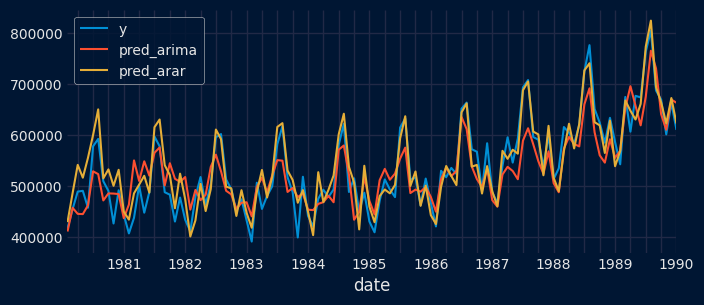

In [19]:
fig, ax = plt.subplots(figsize=(7, 3))
data['y'].loc[data_test.index].plot(ax=ax, label='y')
# pred_sarimax['pred'].plot(ax=ax, label='pred_sarimax')
pred_arima['pred'].plot(ax=ax, label='pred_arima')
pred_arar['pred'].plot(ax=ax, label='pred_arar')
# pred_ets['pred'].plot(ax=ax, label='pred_ets')
ax.legend();

In [20]:
# Train-validation-test data
# ======================================================================================
end_train = '1976-01-01 23:59:59'
end_val = '1984-01-01 23:59:59'
print(
    f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Validation dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_val].index.max()}  "
    f"(n={len(data.loc[end_train:end_val])})"
)
print(
    f"Test dates       : {data.loc[end_val:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_val:])})"
)

Train dates      : 1969-01-01 00:00:00 --- 1976-01-01 00:00:00  (n=85)
Validation dates : 1976-02-01 00:00:00 --- 1984-01-01 00:00:00  (n=96)
Test dates       : 1984-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=72)


In [21]:
# Grid search sarimax
# ==============================================================================
forecaster = ForecasterStats(
                 regressor=Sarimax(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )

param_grid = {
    'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1)],
    'seasonal_order': [(0, 0, 0, 0)],
    'trend': [None, 'n', 'c']
}

cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True,
        fixed_train_size   = False,
    )

resultados_grid = grid_search_stats(
                   forecaster            = forecaster,
                   y                     = data.loc[:end_val, 'y'],
                   cv                    = cv,
                   param_grid            = param_grid,
                   metric                = 'mean_absolute_error',
                   return_best           = False,
                   suppress_warnings_fit = True,
               )
resultados_grid.head(5)

Number of models compared: 15.


params grid:   0%|          | 0/15 [00:00<?, ?it/s]

,params,mean_absolute_error,order,seasonal_order,trend
0,"{'order': (2, 1, 1), 'seasonal_order': (0, 0, ...",43032.096660,"(2, 1, 1)","(0, 0, 0, 0)",None
1,"{'order': (2, 1, 1), 'seasonal_order': (0, 0, ...",43032.096660,"(2, 1, 1)","(0, 0, 0, 0)",n
2,"{'order': (1, 1, 1), 'seasonal_order': (0, 0, ...",44663.232448,"(1, 1, 1)","(0, 0, 0, 0)",n
3,"{'order': (1, 1, 1), 'seasonal_order': (0, 0, ...",44663.232448,"(1, 1, 1)","(0, 0, 0, 0)",None
4,"{'order': (0, 1, 1), 'seasonal_order': (0, 0, ...",54666.187886,"(0, 1, 1)","(0, 0, 0, 0)",c


In [31]:
# Grid search Arar skforecast
# ==============================================================================
forecaster = ForecasterStats(
                 regressor=Arar()
             )

param_grid = {
    'max_ar_depth': [3, 10, 26],
    'max_lag': [3, 10, 20, 40, 60]
}

cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True,
        fixed_train_size   = False,
    )

resultados_grid = grid_search_stats(
                   forecaster            = forecaster,
                   y                     = data.loc[:end_val, 'y'],
                   cv                    = cv,
                   param_grid            = param_grid,
                   metric                = 'mean_absolute_error',
                   return_best           = False,
                   suppress_warnings_fit = True,
               )
resultados_grid.head(5)

Number of models compared: 15.


params grid:   0%|          | 0/15 [00:00<?, ?it/s]

<string>:81: RuntimeWarning: Exception raised for parameters {'max_ar_depth': 10, 'max_lag': 3}.
Parameters skipped. Exception: max_lag must be greater than or equal to max_ar_depth. Got max_lag=3, max_ar_depth=10
<string>:81: RuntimeWarning: Exception raised for parameters {'max_ar_depth': 26, 'max_lag': 3}.
Parameters skipped. Exception: max_lag must be greater than or equal to max_ar_depth. Got max_lag=3, max_ar_depth=26
<string>:81: RuntimeWarning: Exception raised for parameters {'max_ar_depth': 26, 'max_lag': 10}.
Parameters skipped. Exception: max_lag must be greater than or equal to max_ar_depth. Got max_lag=10, max_ar_depth=26
<string>:81: RuntimeWarning: Exception raised for parameters {'max_ar_depth': 26, 'max_lag': 20}.
Parameters skipped. Exception: max_lag must be greater than or equal to max_ar_depth. Got max_lag=20, max_ar_depth=26


,params,mean_absolute_error,max_ar_depth,max_lag
0,"{'max_ar_depth': 10, 'max_lag': 20}",29058.982205,10,20
1,"{'max_ar_depth': 10, 'max_lag': 40}",29058.982205,10,40
2,"{'max_ar_depth': 10, 'max_lag': 10}",29058.982205,10,10
3,"{'max_ar_depth': 10, 'max_lag': 60}",29058.982205,10,60
4,"{'max_ar_depth': 26, 'max_lag': 40}",33183.064655,26,40


In [89]:
# Grid search ARIMA aeon
# ==============================================================================
forecaster = ForecasterStats(
                 regressor=ARIMA(p=12, d=1, q=1, iterations=1000)
             )

param_grid = {
    'p': [0, 1, 2],
    'd': [0, 1, 2],
    'q': [0, 1, 2]
}

cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True,
        fixed_train_size   = False,
    )

resultados_grid = grid_search_stats(
                   forecaster            = forecaster,
                   y                     = data.loc[:end_val, 'y'],
                   cv                    = cv,
                   param_grid            = param_grid,
                   metric                = 'mean_absolute_error',
                   return_best           = False,
                   suppress_warnings_fit = True,
               )
resultados_grid.head(5)

Number of models compared: 27.


params grid:   0%|          | 0/27 [00:00<?, ?it/s]

,params,mean_absolute_error,d,p,q
0,"{'d': 1, 'p': 2, 'q': 2}",40515.499563,1,2,2
1,"{'d': 1, 'p': 0, 'q': 2}",41816.409520,1,0,2
2,"{'d': 1, 'p': 2, 'q': 1}",41982.047696,1,2,1
3,"{'d': 1, 'p': 1, 'q': 2}",42540.359051,1,1,2
4,"{'d': 1, 'p': 1, 'q': 1}",44080.174904,1,1,1
